In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import nltk
import re
import gensim

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import class_weight

from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train = pd.read_csv('/content/drive/My Drive/twitter sentiment/train.csv')

In [5]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [6]:
class_weights = list(class_weight.compute_class_weight('balanced',
                                                       np.unique(train.label),
                                                       train.label))

In [7]:
class_weights.sort()

In [8]:
class_weights

[0.5377187079407806, 7.128010704727921]

In [9]:
weights = {}

In [10]:
for index, weight in enumerate(class_weights):
  weights[index]=weight

In [11]:
weights

{0: 0.5377187079407806, 1: 7.128010704727921}

In [12]:
 train['tweet'][0]

' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'

In [13]:
mapper = {0: "Normal", 1: "Hate_speech"}
def Mapper(label):
    return mapper[int(label)]

In [14]:
train.label = train.label.apply(lambda x: Mapper(x))

# Tweet Cleaning

In [15]:
train.label.value_counts()

Normal         29720
Hate_speech     2242
Name: label, dtype: int64

In [16]:
## So the data is highly imbalanced. Cleaning the data to get started

In [17]:
## Function for cleaning the data

def clean_tweet(text):
    # For removing mentions
    text = re.sub(r'@[A-Za-z0-9]+','', text) 
    
    # For removing Hashtags
    text = re.sub(r'#', '', text)
    
    # For removing RT
    text = re.sub(r'RT[\s]+', '', text)
    
    # For removing Hyperlinks
    text = re.sub(r'https?\/\/\S+', '', text)
    
    # Changing everthing to lowercase
    text = text.lower()
    
    return text

In [18]:
train['clean_tweet'] = train['tweet'].apply(clean_tweet)

In [19]:
train.head()

,id,label,tweet,clean_tweet
0,1,Normal,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,Normal,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i can't use cause the...
2,3,Normal,bihday your majesty,bihday your majesty
3,4,Normal,#model i love u take with u all the time in ...,model i love u take with u all the time in u...
4,5,Normal,factsguide: society now #motivation,factsguide: society now motivation


### Now the basic cleaning is done

In [20]:
train['clean_tweet'][0]

'  when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   run'

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [23]:
stopwords = stopwords.words('english')

In [24]:
stopwords[0]

'i'

In [25]:
example = 'my name is aaron'

In [26]:
example_words = example.split()

In [27]:
result_words = [word for word in example_words if word.lower() not in stopwords]
result = ' '.join(result_words)
        
        
        

In [28]:
print(result)

name aaron


In [29]:
stemmer = SnowballStemmer('english')

In [30]:
def stopword_remover(text, stem=False):
    
    tokens = []
    for token in text.split():
        if token not in stopwords:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [31]:
print(stopword_remover(example))

name aaron


In [32]:
print(stopword_remover('Hi there, what are you upto these days now I hope you are doing well'))

Hi there, upto days I hope well


In [33]:
train.clean_tweet = train.clean_tweet.apply(lambda x: stopword_remover(x))

In [34]:
train.head()

,id,label,tweet,clean_tweet
0,1,Normal,@user when a father is dysfunctional and is s...,father dysfunctional selfish drags kids dysfun...
1,2,Normal,@user @user thanks for #lyft credit i can't us...,thanks lyft credit can't use cause offer wheel...
2,3,Normal,bihday your majesty,bihday majesty
3,4,Normal,#model i love u take with u all the time in ...,model love u take u time urð±!!! ððð...
4,5,Normal,factsguide: society now #motivation,factsguide: society motivation


In [35]:
train.tweet[3]

'#model   i love u take with u all the time in urð\x9f\x93±!!! ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91\x85ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦  '

In [36]:
train.clean_tweet[3]

'model love u take u time urð\x9f\x93±!!! ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91 ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦'

In [37]:
train_, test_ = train_test_split(train, test_size=0.2)
print("TRAIN size:", len(train_))
print("TEST size:", len(test_))

TRAIN size: 25569
TEST size: 6393


In [38]:
clean_tweets = [_clean_tweet.split() for _clean_tweet in train_.clean_tweet]

In [39]:
clean_tweets

[['friday',
  'fitfam!',
  'ready',
  'ridiculous',
  'foodporn?',
  'last',
  'night,',
  'andâ\x80¦'],
 ['cat', 'kitty', 'clifford', 'ponceâ\x84¢:'],
 ['nice1girl',
  '-',
  'na:',
  'horny',
  'slut',
  'kinky',
  'nude',
  'hot',
  'nasty',
  'sexy',
  'porn',
  'naughty',
  'snapshot',
  'xxx',
  'young',
  'wet',
  'shy'],
 ['feel', 'proud', 'everything', 'achieved', 'se1'],
 ['reading',
  '4',
  'next',
  'american',
  'revolution',
  '|',
  'race',
  'intersectionality',
  'language',
  'politics',
  'educationâ\x80¦'],
 ['got',
  'call',
  'yesterday.',
  'mom',
  'diagnosed',
  'stage',
  '3',
  'ovarian',
  'cancer.',
  "i'm",
  'terrified,',
  'terrified.',
  'know',
  'do.'],
 ['let',
  'sun',
  'shine',
  'last',
  'time.',
  'sunset',
  'london',
  'uk',
  'river',
  'summer',
  'goodtimeâ\x80¦'],
 ['live',
  'c.o.w.s',
  'ð\x9f\x8e\x99ï¸\x8f',
  'compensatory',
  'call-in',
  '641.715.3640',
  'code:',
  '564943',
  'iswarâ\x80¦'],
 ['thankful', 'good', 'hugs.', 'thankf

In [40]:
w2v_model = gensim.models.word2vec.Word2Vec(size=300,
                                           window=7,
                                           min_count=10,
                                           
                                           workers= 4)

In [41]:
w2v_model.build_vocab(clean_tweets)

In [42]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print('Vocab size', vocab_size)

Vocab size 2920


In [43]:
w2v_model.train(clean_tweets, total_examples=len(clean_tweets), epochs= 15)

(1923433, 3278490)

In [44]:
w2v_model.most_similar('love')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('forever', 0.881581723690033),
 ('friendship', 0.8622581362724304),
 ('ð\x9f\x92\x95', 0.8597669005393982),
 ('lovelife', 0.8475850820541382),
 ('married', 0.8462587594985962),
 ('â\x9d¤ï¸\x8f', 0.8434244394302368),
 ('smiles', 0.83552086353302),
 ('bestfriends', 0.8219481706619263),
 ('bride', 0.8157219886779785),
 ('nofilter', 0.8115202784538269)]

In [45]:
tokenizer = Tokenizer()

In [46]:
tokenizer.fit_on_texts(train_.clean_tweet,)
vocab_size = len(tokenizer.word_index) + 1
print('Total words', vocab_size)

Total words 39724


In [47]:
train_

,id,label,tweet,clean_tweet
5427,5428,Normal,#friday #fitfam! who is ready for some ridic...,friday fitfam! ready ridiculous foodporn? last...
13123,13124,Normal,#cat #kitty clifford ponceâ¢:,cat kitty clifford ponceâ¢:
20895,20896,Normal,nice1girl - na: #horny #slut #kinky #nude #hot...,nice1girl - na: horny slut kinky nude hot nast...
21789,21790,Normal,feel so proud of everything i have achieved in...,feel proud everything achieved se1
5259,5260,Hate_speech,@user reading 4 the next american #revolution ...,reading 4 next american revolution | race inte...
...,...,...,...,...
964,965,Normal,i can already tell that next week's episode is...,already tell next week's episode gonna give in...
5027,5028,Normal,@user this is the year of change - from blue ...,year change - blue green changinglives busines...
1385,1386,Normal,#congrats to my #boy olu_shola #married #lif...,congrats boy olu_shola married life good peopl...
6225,6226,Normal,mood = ð»,mood = ð»


In [48]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_.clean_tweet), maxlen=300)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_.clean_tweet), maxlen=300)

In [49]:
encoder = LabelEncoder()
encoder.fit(train_.label.tolist())

y_train = encoder.transform(train_.label.tolist())
y_test = encoder.transform(test_.label.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (25569, 1)
y_test (6393, 1)


In [50]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (25569, 300)
y_train (25569, 1)

x_test (6393, 300)
y_test (6393, 1)


In [51]:
y_train[:10]

array([[1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1]])

In [52]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(39724, 300)


In [53]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

In [54]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          11917200  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 12,077,701
Trainable params: 160,501
Non-trainable params: 11,917,200
_________________________________________________________________


In [55]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [56]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [57]:
history = model.fit(x_train, y_train,
                    epochs=5,
                    validation_data = (x_test, y_test),
                    class_weight = weights,
                    callbacks=callbacks)

Epoch 1/5
800/800 [==============================] - 827s 1s/step - loss: 0.2246 - accuracy: 0.9305 - val_loss: 0.2914 - val_accuracy: 0.9338
Epoch 2/5
800/800 [==============================] - 800s 1s/step - loss: 0.1739 - accuracy: 0.9355 - val_loss: 0.2759 - val_accuracy: 0.9340
Epoch 3/5
800/800 [==============================] - 814s 1s/step - loss: 0.1662 - accuracy: 0.9378 - val_loss: 0.2632 - val_accuracy: 0.9396
Epoch 4/5
800/800 [==============================] - 802s 1s/step - loss: 0.1643 - accuracy: 0.9379 - val_loss: 0.2264 - val_accuracy: 0.9415
Epoch 5/5
800/800 [==============================] - 814s 1s/step - loss: 0.1604 - accuracy: 0.9389 - val_loss: 0.2504 - val_accuracy: 0.9426


In [58]:
score = model.evaluate(x_test, y_test)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

200/200 [==============================] - 16s 79ms/step - loss: 0.2504 - accuracy: 0.9426

ACCURACY: 0.9425934553146362
LOSS: 0.250438392162323


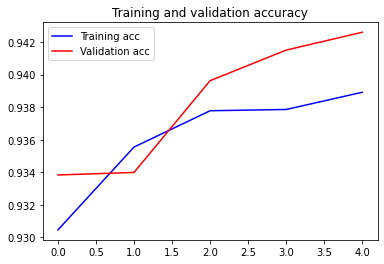

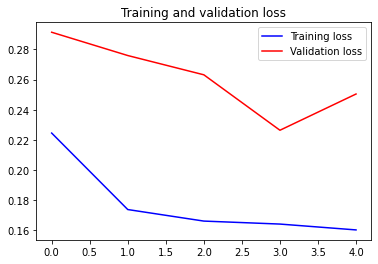

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()
